# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy.linalg

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {k: i for i, k in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        # Check if the word is in the dictionary
        if w not in self.word2vec.keys():
            print("Word {} not in vocabulary".format(w))
            return []
        # Compute the score of each word
        scores = [self.score(w, w1) for w1 in self.word2vec.keys()]
        # Get the K best word
        K_best = np.argsort(scores)[-5:][::-1]
        return [self.id2word[k] for k in K_best]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        # Check if we know the word
        if w1 not in self.word2vec.keys():
            print("Word {} not in vocabulary".format(w1))
            return 0
        elif w2 not in self.word2vec.keys():
            print("Word {} not in vocabulary".format(w2))
            return 0
        else:
            # Compute the word norms and their cosine distance
            n1, n2 = np.linalg.norm(self.word2vec[w1]), np.linalg.norm(self.word2vec[w2])
            return np.dot(self.word2vec[w1], self.word2vec[w2]) / (n1 * n2)

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000) # 25000

#################################################
# REMARK : we had to augment the number of words
#          in order to get paris and germany,
#          which were above 25k, and under 100k
#################################################

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'pooches', 'Dogs', 'doggies']
['paris', 'france', 'Paris', 'london', 'berlin']
['germany', 'austria', 'europe', 'german', 'berlin']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            words = sent.split(' ')
            if idf is False:
                # mean of word vectors
                # Retrieve the word embeddings
                vectors = [self.w2v.word2vec[w] for w in words if w in w2v.word2vec]
                # If there is none
                if len(vectors) == 0:
                    sentemb.append(np.zeros_like(list(w2v.word2vec.values())[0]))
                else:
                    sentemb.append(np.mean(vectors, axis=0))
            else:
                # idf-weighted mean of word vectors
                weighted_vectors = [self.w2v.word2vec[w]*idf[w] for w in words if w in w2v.word2vec]
                if len(weighted_vectors) == 0:
                    sentemb.append(np.zeros_like(list(w2v.word2vec.values())[0]))
                else:
                    sentemb.append(np.mean(weighted_vectors, axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        # Compute the score of each sentence
        scores = [self.score(s, s1, idf) for s1 in sentences]
        # Get the K best sentences
        K_best = np.argsort(scores)[-5:]
        for rank, k in enumerate(reversed(K_best)):
            print(str(rank+1) + " : " + sentences[k][:-2])
        return

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        # Encode both sentences :
        e1 = self.encode([s1], idf)
        e2 = self.encode([s2], idf)
        # Compute their norms :
        n1, n2 = np.linalg.norm(e1), np.linalg.norm(e2)
        if n1 == 0 or n2 == 0:
            return 0
        else:
            # Return cosine distance
            return e1[0].dot(e2[0]) / (n1 * n2)
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split(' ')):
                idf[w] = idf.get(w, 0) + 1
        for w in idf.keys():
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        return idf

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
f = open(os.path.join(PATH_TO_DATA, 'sentences.txt'))
sentences = f.readlines()
f.close()

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print("Without IDF, sentence : {}".format(sentences[10]))
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

print("With IDF, sentence : {}".format(sentences[10]))
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors
Without IDF, sentence : 1 smiling african american boy . 

1 : 1 smiling african american boy .
2 : blond boy waterskiing .
3 : a boy jumps .
4 : a boy jumps .
5 : a boy smiles underwater .
0.6089445116147133
With IDF, sentence : 1 smiling african american boy . 

1 : 1 smiling african american boy .
2 : 5 women and 1 man are smiling for the camera .
3 : a man rides a 4 wheeler in the desert .
4 : 3 males and 1 woman enjoying a sporting event
5 : a man in black is juggling 3 flamed bottles .
0.5963335652885751


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
common_words = [w for w in w2v_en.word2vec.keys() if w in w2v_fr.word2vec.keys()]
X = np.concatenate([w2v_en.word2vec[w][None] for w in common_words], axis=0).T # X is english
Y = np.concatenate([w2v_fr.word2vec[w][None] for w in common_words], axis=0).T # Y is french

In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
Z = Y.dot(X.T)
svd = scipy.linalg.svd(Z)
U, S, Vh = svd
W = U.dot(Vh)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
def score(v1, v2):
    n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if n1 == 0 or n2 == 0:
        return 0
    else:
        return v1.dot(v2) / (n1*n2)
    
def most_similar_word(w1, w2v_1, w2v_2, embedding):
    vec_1 = w2v_1.word2vec[w1]
    vec_2 = embedding.dot(vec_1)
    scores = [score(vec_2, w2v_2.embeddings[k, :]) for k in range(w2v_2.embeddings.shape[0])]
    best = np.argmax(scores)
    return w2v_2.id2word[best]

print("French to English :")
for w in ["maison", "mois", "soir", "voiture", "je", "félin", "sentir"]:
    w2 = most_similar_word(w, w2v_fr, w2v_en, W.T)
    print(w, w2)
    
print("\nEnglish to French :")
for w in ["pants", "month", "immediate", "puppet", "tortoise", "hypothetical"]:
    w2 = most_similar_word(w, w2v_en, w2v_fr, W)
    print(w, w2)

French to English :
maison house
mois months
soir evening
voiture car
je s/he
félin feline
sentir perceive

English to French :
pants pantalons
month mois
immediate immédiat
puppet marionnette
tortoise tortue
hypothetical hypothétique


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def read_raw(raw):
    sentences = []
    labels = []
    for line in raw:
        label, sentence = line.split(" ", 1)
        sentences.append(sentence)
        labels.append(int(label))
    return sentences, labels

f = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
sst_train_raw = f.readlines()
f.close()
f = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
sst_dev_raw = f.readlines()
f.close()
f = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))
sst_test = f.readlines()
f.close()

sst_train, label_train = read_raw(sst_train_raw)
sst_dev, label_dev = read_raw(sst_dev_raw)

In [12]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=50000)
s2v = BoV(w2v)
idf_sst = s2v.build_idf(sst_train + sst_dev + sst_test)
bov_train_idf = s2v.encode(sst_train, idf_sst)
bov_dev_idf = s2v.encode(sst_dev, idf_sst)
bov_test_idf = s2v.encode(sst_test, idf_sst)
bov_train_mean = s2v.encode(sst_train, idf=False)
bov_dev_mean = s2v.encode(sst_dev, idf=False)
bov_test_mean = s2v.encode(sst_test, idf=False)

Loaded 50000 pretrained word vectors


Best BoV-mean accuracy : 0.4187102633969119
Best BoV-idf accuracy : 0.39872842870118075


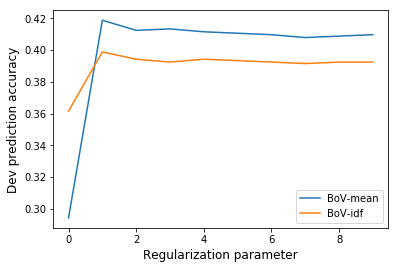

In [16]:
##### 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Parameter selection without idf
Cs = np.linspace(1e-3, 8, 10)
accuracy_mean = []
for C in Cs:
    classifier = LogisticRegression(penalty="l2", C=C, solver="liblinear", multi_class='ovr', tol=1e-6)
    classifier.fit(bov_train_mean, label_train)
    prediction = classifier.predict(bov_dev_mean)
    accuracy = np.mean(prediction == label_dev)
    accuracy_mean.append(accuracy)

# Parameter selection with idf
accuracy_idf = []
for C in Cs:
    classifier = LogisticRegression(penalty="l2", C=C, solver="liblinear", multi_class='ovr', tol=1e-6)
    classifier.fit(bov_train_idf, label_train)
    prediction = classifier.predict(bov_dev_idf)
    accuracy = np.mean(prediction == label_dev)
    accuracy_idf.append(accuracy)

C_mean = Cs[np.argmax(accuracy_mean)]
C_idf = Cs[np.argmax(accuracy_mean)]

print("Best BoV-mean accuracy : {}".format(max(accuracy_mean)))
print("Best BoV-idf accuracy : {}".format(max(accuracy_idf)))
plt.plot(accuracy_mean, label="BoV-mean")
plt.plot(accuracy_idf, label="BoV-idf")
plt.xlabel("Regularization parameter", fontsize=12)
plt.ylabel("Dev prediction accuracy", fontsize=12)
plt.legend()
plt.show()

In [17]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
best_classifier = LogisticRegression(penalty="l2", C=C_mean, solver="liblinear", multi_class='ovr', tol=1e-6)
best_classifier.fit(bov_train_mean, label_train)
prediction_test = best_classifier.predict(bov_test_mean)
text_to_write = "\n".join(prediction_test.astype(str))
f = open("logreg_bov_y_test_sst.txt", "w")
f.write(text_to_write)
f.close()

In [23]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
import xgboost as xgb

classifier_xgb_mean = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05, n_jobs=4)
classifier_xgb_mean.fit(bov_train_mean, label_train)
prediction_mean = classifier_xgb_mean.predict(bov_dev_mean)
accuracy_mean = np.mean(prediction_mean == label_dev)
print("XGBoost bov-mean accuracy : {}".format(accuracy_mean))

classifier_xgb_idf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05, n_jobs=4)
classifier_xgb_idf.fit(bov_train_idf, label_train)
prediction_idf = classifier_xgb_idf.predict(bov_dev_idf)
accuracy_idf = np.mean(prediction_idf == label_dev)
print("XGBoost bov-idf accuracy : {}".format(accuracy_idf))

# We take bov-mean, which is better
prediction_test = classifier_xgb_mean.predict(bov_test_mean)
text_to_write = "\n".join(prediction_test.astype(str))
f = open("xgb_bov_y_test_sst.txt", "w")
f.write(text_to_write)
f.close()

XGBoost bov-mean accuracy : 0.4187102633969119
XGBoost bov-idf accuracy : 0.3923705722070845


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [1]:
import keras

Using TensorFlow backend.


In [5]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "data/"

# TYPE CODE HERE
def read_raw(raw):
    sentences = []
    labels = []
    for line in raw:
        label, sentence = line.split(" ", 1)
        sentences.append(sentence)
        labels.append(int(label))
    return sentences, labels
f = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
sst_train_raw = f.readlines()
f.close()
f = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
sst_dev_raw = f.readlines()
f.close()
f = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))
sst_test = f.readlines()
f.close()

sst_train, label_train = read_raw(sst_train_raw)
sst_dev, label_dev = read_raw(sst_dev_raw)

In [44]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
n_vocab = 5000
def one_hot_array(array):
    res = []
    for sentence in array:
        res.append(keras.preprocessing.text.one_hot(sentence, n=n_vocab))
    return res

x_train = one_hot_array(sst_train)
x_dev = one_hot_array(sst_dev)
x_test = one_hot_array(sst_test)
y_train = keras.utils.np_utils.to_categorical(label_train)
y_dev = keras.utils.np_utils.to_categorical(label_dev)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [45]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=52)
x_dev = keras.preprocessing.sequence.pad_sequences(x_dev, maxlen=52)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=52)

## 4.2 - Design and train your model

In [66]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout

embed_dim  = 100      # word embedding dimension
nhid       = 64      # number of hidden units in the LSTM
vocab_size = n_vocab  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))

In [67]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adagrad' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 542,565
Trainable params: 542,565
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 16 # Reducing the batch size improves slightly the performance
n_epochs = 6

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 53s 6ms/step - loss: 1.5002 - acc: 0.3405 - val_loss: 1.4343 - val_acc: 0.3678
Epoch 2/6
8544/8544 [==============================] - 50s 6ms/step - loss: 1.2787 - acc: 0.4483 - val_loss: 1.3883 - val_acc: 0.3969
Epoch 3/6
8544/8544 [==============================] - 51s 6ms/step - loss: 1.1403 - acc: 0.5217 - val_loss: 1.4171 - val_acc: 0.3824
Epoch 4/6
8544/8544 [==============================] - 50s 6ms/step - loss: 1.0335 - acc: 0.5813 - val_loss: 1.4805 - val_acc: 0.3769
Epoch 5/6
8544/8544 [==============================] - 175s 21ms/step - loss: 0.9420 - acc: 0.6259 - val_loss: 1.5484 - val_acc: 0.3660
Epoch 6/6
8544/8544 [==============================] - 47s 5ms/step - loss: 0.8618 - acc: 0.6706 - val_loss: 1.6414 - val_acc: 0.3842


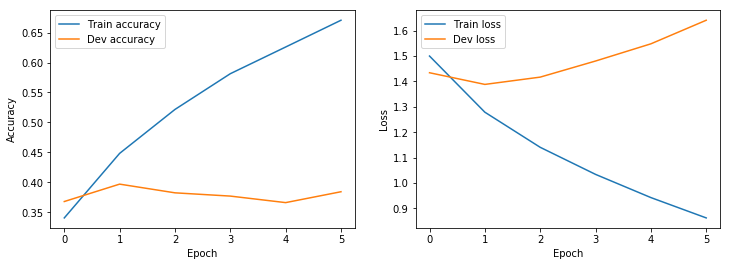

In [77]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
y_test_pred = model.predict(x_test)
text_to_write = "\n".join(y_test_pred.max(axis=1).astype(str))
f = open("logreg_lstm_y_test_sst.txt", "w")
f.write(text_to_write)
f.close()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["acc"], label="Train accuracy")
plt.plot(history.history["val_acc"], label="Dev accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Dev loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 4.3 -- innovate !

In [111]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
embed_dim  = 32      # word embedding dimension
vocab_size = n_vocab  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=52))
model.add(Conv1D(16, 5, activation='relu'))
model.add(MaxPooling1D(2, 2))
model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(2, 2))
model.add(Flatten())
model.add(Dropout(0.7))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

bs = 64
n_epochs = 20

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/20
8544/8544 [==============================] - 5s 614us/step - loss: 1.5761 - acc: 0.2699 - val_loss: 1.5703 - val_acc: 0.2616
Epoch 2/20
8544/8544 [==============================] - 1s 111us/step - loss: 1.5567 - acc: 0.2959 - val_loss: 1.5679 - val_acc: 0.2861
Epoch 3/20
8544/8544 [==============================] - 1s 113us/step - loss: 1.5431 - acc: 0.3079 - val_loss: 1.5588 - val_acc: 0.3124
Epoch 4/20
8544/8544 [==============================] - 1s 120us/step - loss: 1.5135 - acc: 0.3343 - val_loss: 1.5360 - val_acc: 0.3406
Epoch 5/20
8544/8544 [==============================] - 1s 142us/step - loss: 1.4566 - acc: 0.3729 - val_loss: 1.4943 - val_acc: 0.3651
Epoch 6/20
8544/8544 [==============================] - 1s 129us/step - loss: 1.3857 - acc: 0.4011 - val_loss: 1.4676 - val_acc: 0.3697
Epoch 7/20
8544/8544 [==============================] - 1s 113us/step - loss: 1.3235 - acc: 0.4311 - val_loss: 1.4550 - val_acc: 0.3688


In [112]:
y_test_pred = model.predict(x_test)
text_to_write = "\n".join(y_test_pred.max(axis=1).astype(str))
f = open("logreg_cnn_y_test_sst.txt", "w")
f.write(text_to_write)
f.close()